In [1]:
import numpy as np
import pyomo.environ as pyo
from pyomo.environ import ConcreteModel, Var, ConstraintList, Objective, SolverFactory, value, RangeSet

import jax
import jax.numpy as jnp
from jax import jit
from jax.random import PRNGKey
from jax.experimental.ode import odeint
from flax import linen as nn
from flax.training import train_state
import optax

# -------------- helper libraries -------------- #
import sys
import os
import time
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from jax import random

collocation2_path = os.path.abspath(os.path.join('..', 'utils'))

# Add the directory to sys.path
if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation import compute_weights, lagrange_derivative
from interpolation import BarycentricInterpolation
from data_generation import generate_ode_data
from non_parametric_collocation import collocate_data
from optimization_pyomo import ODEOptimizationModel as ODEOptimizationModel
from pickle_func import pickle_data, unpickle_data

# -------------- regular neural nets --------------
from neural_net import NeuralODE

In [4]:
import importlib
import neural_net

importlib.reload(neural_net)
NeuralODE = neural_net.NeuralODE

import data_generation
importlib.reload(data_generation)
generate_ode_data = data_generation.generate_ode_data


import non_parametric_collocation
importlib.reload(non_parametric_collocation)
collocate_data = non_parametric_collocation.collocate_data

### `1.1 JAX neural net using DIFFRAX`

In [15]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import grad, jit, value_and_grad
from jax.experimental import host_callback
import optax

from flax import linen as nn
from flax.training import train_state
from jax import random
import flax.linen.initializers as initializers
import diffrax as dfx

class NeuralODE(nn.Module):
    layer_widths: list
    time_invariant: bool = True
    loss: int = 0
    max_iter: int = np.inf
    regularizer: float = 1e-5

    @nn.compact
    def __call__(self, x):
        for width in self.layer_widths[:-1]:
            x = nn.Dense(width, kernel_init=initializers.lecun_normal())(x)
            x = nn.tanh(x)
        x = nn.Dense(self.layer_widths[-1], kernel_init=initializers.lecun_normal())(x)
        return x

    def create_train_state(self, rng, learning_rate, regularizer=1e-5):
        self.regularizer = regularizer
        
        params = self.init(rng, jnp.ones((self.layer_widths[0],)))['params']
        tx = optax.adam(learning_rate)
        return train_state.TrainState.create(apply_fn=self.apply, params=params, tx=tx)

    def loss_fn(self, params, apply_fn, t, observed_data, y0, args):
        def func(t, y, args):
            # print("t: ", t)
            input = jnp.atleast_1d(y)

            if not self.time_invariant:
                input = jnp.append(input, t)

            if args is not None:
                extra_inputs, t_all = args

                if isinstance(extra_inputs, (np.ndarray, jnp.ndarray)):
                    # Interpolate extra_inputs to get continuous values
                    if extra_inputs.ndim == 2:
                        interpolated_inputs = jnp.array([linear_interpolate(t, t_all, extra_inputs[:, i]) for i in range(extra_inputs.shape[1])])
                        input = jnp.append(input, interpolated_inputs)
                    elif extra_inputs.ndim == 1:
                        interpolated_input = linear_interpolate(t, t_all, extra_inputs)
                        input = jnp.append(input, interpolated_input)
                else:
                    input = jnp.append(input, extra_inputs)

            result = apply_fn({'params': params}, input)
            return result
        
        solver = dfx.Tsit5()
        stepsize_controller = dfx.PIDController(rtol=1e-3, atol=1e-6)
        saveat = dfx.SaveAt(ts=t)

        solution = dfx.diffeqsolve(
            dfx.ODETerm(func),
            solver,
            t0=t[0],
            t1=t[-1],
            dt0=1e-3,
            y0=y0,
            args=args,
            stepsize_controller=stepsize_controller,
            saveat=saveat
        )

        #debug_print_simple(solution.ts)
        
        pred_solution = solution.ys
        loss_mse = jnp.sum(jnp.square(pred_solution - observed_data))
        l2_regularization = sum(jnp.sum(param ** 2) for param in jax.tree_util.tree_leaves(params))
        
        return loss_mse + self.regularizer * l2_regularization

    def train_step(self, state, t, observed_data, y0, extra_args):
        grad_fn = jax.value_and_grad(self.loss_fn)
        loss, grads = grad_fn(state.params, state.apply_fn, t, observed_data, y0, extra_args)
        state = state.apply_gradients(grads=grads)
        return state, loss

    def train(self, state, t, observed_data, y0, num_epochs=np.inf, loss=0, extra_args=None):
        self.loss = loss
        self.max_iter = num_epochs
        
        @jax.jit
        def train_step_jit(state, t, observed_data, y0, extra_args):
            return self.train_step(state, t, observed_data, y0, extra_args)

        epoch = 0
        while True:
            epoch += 1
            state, loss = train_step_jit(state, t, observed_data, y0, extra_args)
            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss}')
            if loss < self.loss or epoch > self.max_iter:
                break
        return state

    def neural_ode(self, params, y0, t, state, extra_args=None): 
        def func(t, y, args):
            input = jnp.atleast_1d(y)
            #print('t: ', t)
            #print('extra_args: ', extra_args[1])
            #print('y0: ', y0)
            if not self.time_invariant:
                input = jnp.append(input, t)

            if args is not None:
                extra_inputs, t_all = args
                if isinstance(extra_inputs, (np.ndarray, jnp.ndarray)):
                    # interpolate extra_inputs to get continuous values
                    if extra_inputs.ndim == 2:
                        interpolated_inputs = jnp.array([linear_interpolate(t, t_all, extra_inputs[:, i]) for i in range(extra_inputs.shape[1])])
                        input = jnp.append(input, interpolated_inputs)
                    elif extra_inputs.ndim == 1:
                        interpolated_input = linear_interpolate(t, t_all, extra_inputs)
                        input = jnp.append(input, interpolated_input)
                else:
                    input = jnp.append(input, extra_inputs)

            result = state.apply_fn({'params': params}, input)
            #print("Result: ")
            #debug_print(result, transform=lambda x: f"Result: {x}") 
            return result
        
        term = dfx.ODETerm(func)
        solver = dfx.Tsit5()
        stepsize_controller = dfx.PIDController(rtol=1e-3, atol=1e-6)
        saveat = dfx.SaveAt(ts=t)

        #print(f"t: {t}")
        #print(f"t1: {t[-1]}")
        #print(f"t0: {t[0]}")
        #print(f"y0: {y0}")
        #debug_print_simple(y0)
        #print("enter solver:")
        solution = dfx.diffeqsolve(
            term, # function
            solver,
            t0=t[0],
            t1=t[-1],
            dt0=1e-4,
            y0=y0,
            args=extra_args,
            stepsize_controller=stepsize_controller,
            saveat=saveat
        )
        #print("solution.ts", solution.ts)
        return solution.ys


def linear_interpolate(x, xp, yp):
    """
    Interpolate data points (xp, yp) to find the value at x.
    """
    return jnp.interp(x, xp, yp)

def debug_print_simple(value):
    """A function to print during JIT execution using host_callback.id_tap."""
    def print_func(x, _):
        print(x)
        return x  
    return host_callback.id_tap(print_func, value)


def debug_print(value, transform=lambda x: x):
    """A function to print during JIT execution using host_callback.id_tap."""
    def print_func(x, _):
        print(transform(x))
        return x  
    return host_callback.id_tap(print_func, value)


## Harmonic Oscillator

### `1.0 generate data`

In [7]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.2
ode_type, params = "harmonic_oscillator", {"omega_squared": 2}
start_time, end_time = 0, 10
spacing_type = "equally_spaced" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_ho, y_ho, y_noisy_ho, true_derivatives_ho = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy_ho = np.array(jnp.squeeze(y_noisy_ho))
t_ho = np.array(jnp.squeeze(t_ho))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
#weights_ho = compute_weights(t_ho)
#D_ho = np.array(lagrange_derivative(t_ho, weights_ho))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test_ho, y_test_ho, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, 20, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
# estimated_derivative_ho, estimated_solution_ho = collocate_data(y_noisy_ho, t_ho, 'EpanechnikovKernel', bandwidth=0.5)

In [9]:
y_pred_results = {}

layer_widths = [2, 64, 64, 2]
learning_rate = 1e-3
rng = PRNGKey(0)

neural_ode_model = NeuralODE(layer_widths=layer_widths, time_invariant=True)
state = neural_ode_model.create_train_state(rng, learning_rate)

start_timer = time.time()
# train(self, state, t, observed_data, y0, num_epochs=1000):
trained_state = neural_ode_model.train(state, t_ho, y_noisy_ho, initial_state, num_epochs=1000)
end_timer = time.time()
timer = end_timer - start_timer
print(f"Time elapsed: {timer}")

y_train_pred = neural_ode_model.neural_ode(trained_state.params, initial_state, t_ho, trained_state)

#---------------------------------------------SAVE RESULT---------------------------------------------#
y1 = y_train_pred[-1, :]

# def neural_ode(self, params, y0, t, state):
y_test_pred = neural_ode_model.neural_ode(trained_state.params, y1, t_test_ho[N-1:], trained_state)
y_pred_results[0] = {"y_train_pred": y_train_pred, "y_test_pred": y_test_pred,
                            "time_elapsed": timer, "y_noisy":y_noisy_ho}


Epoch 100, Loss: 38.781372046359
Epoch 200, Loss: 15.44796311187925
Epoch 300, Loss: 14.545028913903895
Epoch 400, Loss: 14.432040486105937
Epoch 500, Loss: 14.415053060747857
Epoch 600, Loss: 14.40841467455904
Epoch 700, Loss: 14.405151869986458
Epoch 800, Loss: 14.40209858725365
Epoch 900, Loss: 14.398954806116585
Epoch 1000, Loss: 14.449573568771138
Time elapsed: 3.4323439598083496


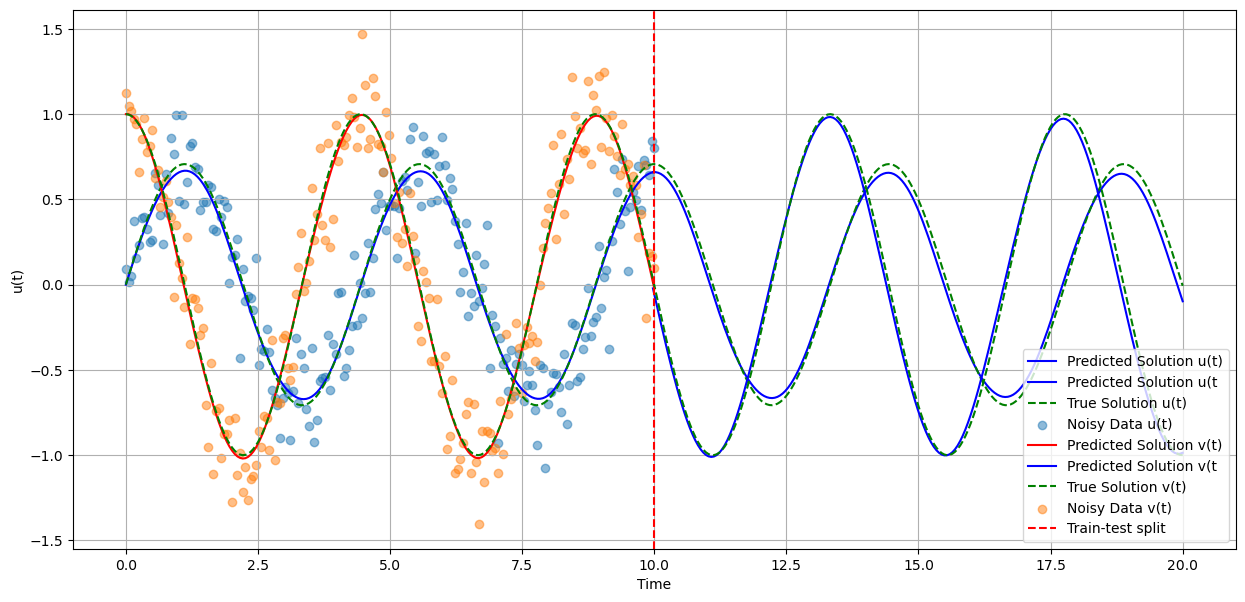

In [10]:
result = y_pred_results[0]

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
plt.plot(t_ho, result['y_train_pred'].T[0], 'b', label='Predicted Solution u(t)')
plt.plot(t_test_ho[N-1:], result['y_test_pred'].T[0], 'b', label='Predicted Solution u(t')
plt.plot(t_test_ho, y_test_ho.T[0], 'g--', label='True Solution u(t)')
plt.scatter(t_ho, y_noisy_ho.T[0], label='Noisy Data u(t)', alpha = 0.5)

plt.plot(t_ho, result['y_train_pred'].T[1], 'r', label='Predicted Solution v(t)')
plt.plot(t_test_ho[N-1:], result['y_test_pred'].T[1], 'b', label='Predicted Solution v(t')
plt.plot(t_test_ho, y_test_ho.T[1], 'g--', label='True Solution v(t)')
plt.scatter(t_ho, y_noisy_ho.T[1], label='Noisy Data v(t)', alpha = 0.5)

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=end_time, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

### `1.2` Optimization with constraints in Pyomo, Ipopt, + regularization

In [186]:
class ODEOptimizationModel:
    def __init__(self, y_observed, t, first_derivative_matrix, layer_sizes, extra_input = None, penalty_lambda=100, max_iter=500, act_func="tanh", w_init_method="random", y_init = None):
        self.y_observed = y_observed
        self.t = t
        self.first_derivative_matrix = first_derivative_matrix
        self.penalty_lambda = penalty_lambda
        self.max_iter = max_iter
        self.act_func = act_func
        self.w_init_method = w_init_method
        self.layer_sizes = layer_sizes
        self.model = ConcreteModel()
        self.y_init = y_init
        self.w_init_method = w_init_method
        self.extra_input = extra_input # only 1D input is supported for now

    def initialize_weights(self, shape):
        if self.w_init_method == 'random':
            return np.random.randn(*shape) * 0.1
        elif self.w_init_method == 'xavier':
            return np.random.randn(*shape) * np.sqrt(2 / (shape[0] + shape[1]))
        elif self.w_init_method == 'he':
            return np.random.randn(*shape) * np.sqrt(2 / shape[0])
        else:
            raise ValueError("Unsupported initialization method. Use 'random', 'xavier', or 'he'.")

    def initialize_biases(self, size):
        return np.random.randn(size) * 0.1

    def build_model(self):
        N = len(self.t)
        model = self.model
        model.t_idx = RangeSet(0, N - 1)

        lower_bound = -10.0
        upper_bound = 10.0
        
        if self.y_init == None:
            model.u = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=0.1, bounds=(lower_bound, upper_bound))
            model.v = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=0.1, bounds=(lower_bound, upper_bound))
        else:
            model.u = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=np.array(self.y_init[0]), bounds=(lower_bound, upper_bound))
            model.v = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=np.array(self.y_init[1]), bounds=(lower_bound, upper_bound))

        if len(self.layer_sizes) == 3:
            input_size = self.layer_sizes[0]
            hidden_size = self.layer_sizes[1]
            output_size = self.layer_sizes[2]

            weight_bounds = (-100.0, 100.0)

            model.W1 = pyo.Var(range(hidden_size), range(input_size), initialize=lambda m, i, j: self.initialize_weights((hidden_size, input_size))[i, j], bounds=weight_bounds)
            model.b1 = pyo.Var(range(hidden_size), initialize=lambda m, i: self.initialize_biases(hidden_size)[i], bounds=weight_bounds)
            model.W2 = pyo.Var(range(output_size), range(hidden_size), initialize=lambda m, i, j: self.initialize_weights((output_size, hidden_size))[i, j], bounds=weight_bounds)
            model.b2 = pyo.Var(range(output_size), initialize=lambda m, i: self.initialize_biases(output_size)[i], bounds=weight_bounds)
            
            # >>>>>>>>>>>>>>>>>>>>> BATCH NORMALIZATION <<<<<<<<<<<<<<<<<<<< #
            """model.gamma1 = pyo.Var(range(hidden_size), initialize=1.0)
            model.beta1 = pyo.Var(range(hidden_size), initialize=0.0)
            model.gamma2 = pyo.Var(range(output_size), initialize=1.0)
            model.beta2 = pyo.Var(range(output_size), initialize=0.0)"""
            # >>>>>>>>>>>>>>>>>>>>> BATCH NORMALIZATION <<<<<<<<<<<<<<<<<<<< #
            
        # >>>>>>>>>>>>>>>>>>>>> CONSTRAINTS METHOD 0 <<<<<<<<<<<<<<<<<<<< #
        penalty_terms = []
        model.ode = ConstraintList()
        for i in range(1, N):
            du_dt = sum(self.first_derivative_matrix[i, j] * model.u[j] for j in range(N))
            dv_dt = sum(self.first_derivative_matrix[i, j] * model.v[j] for j in range(N))
            
            nn_input = [model.u[i], model.v[i]]
            
            if self.extra_input is not None:
                nn_input.append(self.extra_input[i])
                
            nn_u, nn_v = self.nn_output(nn_input, model)

            model.ode.add((nn_u - du_dt)**2 <= 0.1)
            model.ode.add((nn_v - dv_dt)**2 <= 0.1)
            
        def _objective(m):
            data_fit = sum((m.u[i] - self.y_observed[i, 0])**2 + (m.v[i] - self.y_observed[i, 1])**2 for i in m.t_idx)
            smoothing_u = sum((m.u[i+1] - m.u[i])**2 for i in range(len(m.t_idx)-1))
            smoothing_v = sum((m.v[i+1] - m.v[i])**2 for i in range(len(m.t_idx)-1))
            smoothing_term = (smoothing_u + smoothing_v)
            
            reg = sum(m.W1[j, k]**2 for j in range(self.layer_sizes[1]) for k in range(self.layer_sizes[0])) + \
            sum(m.W2[j, k]**2 for j in range(self.layer_sizes[2]) for k in range(self.layer_sizes[1])) + \
            sum(m.b1[j]**2 for j in range(self.layer_sizes[1])) + \
            sum(m.b2[j]**2 for j in range(self.layer_sizes[2]))
            
            return data_fit + reg*0.1

        model.obj = Objective(rule=_objective, sense=pyo.minimize)
        self.model = model 
            
    def nn_output(self, nn_input, m):

        if len(self.layer_sizes) == 3:
            hidden = [sum(m.W1[j, k] * nn_input[k] for k in range(self.layer_sizes[0])) + m.b1[j] for j in range(self.layer_sizes[1])]
            
            # >>>>>>>>>>>>>>>>>>>>> BATCH NORMALIZATION <<<<<<<<<<<<<<<<<<<< #
            """mean_hidden = sum(hidden) / len(hidden)
            var_hidden = sum((h - mean_hidden)**2 for h in hidden) / len(hidden)
            hidden_norm = [(h - mean_hidden) / pyo.sqrt(var_hidden + 1e-5) for h in hidden]
            hidden_bn = [m.gamma1[j] * hidden_norm[j] + m.beta1[j] for j in range(len(hidden_norm))]"""
            # >>>>>>>>>>>>>>>>>>>>> BATCH NORMALIZATION <<<<<<<<<<<<<<<<<<<< #
            
            if self.act_func == "tanh":
                hidden = [pyo.tanh(h) for h in hidden]
            elif self.act_func == "sigmoid":
                hidden = [1 / (1 + pyo.exp(-h)) for h in hidden]
            elif self.act_func == "softplus":
                hidden = [pyo.log(1 + pyo.exp(h)) for h in hidden]
            outputs = [sum(m.W2[j, k] * hidden[k] for k in range(self.layer_sizes[1])) + m.b2[j] for j in range(self.layer_sizes[2])]
            return outputs  # Ensure outputs are returned

    def solve_model(self):
        solver = pyo.SolverFactory('ipopt')
        
        if self.max_iter:
            solver.options['max_iter'] = self.max_iter
            
        solver.options['print_level'] = 5
        tol = 10
        solver.options['tol'] = tol
        solver.options['constr_viol_tol'] = tol
        solver.options["dual_inf_tol"] = tol
        solver.options["compl_inf_tol"] = tol
        
        # solver.options['bound_relax_factor'] = 1e-1  # Default is 1e-8
        # solver.options['compl_inf_tol'] = 1e-2
        # solver.options['dual_inf_tol'] = 10000
        # solver.options['nlp_scaling_method'] = 'gradient-based'  # Or 'user-scaling'
        # solver.options['mu_strategy'] = 'adaptive' # 'monotone'
        # solver.options['check_derivatives_for_naninf'] = 'yes'
        solver.options['halt_on_ampl_error'] = 'yes'
        # solver.options['linear_solver'] = 'mumps'  # Or try 'ma27', 'ma57', 'ma86' if available #DEFAULT 'mumps'
        
        result = solver.solve(self.model, tee=True)
        
        # ------------------- Extract solver information -------------------
        solver_time = result.solver.time
        termination_condition = result.solver.termination_condition
        message = result.solver.message
        
        # ----------------- Extracted information in a dictionary ----------
        solver_info = {
            'solver_time': solver_time,
            'termination_condition': termination_condition,
            'message': message
        }
        
        return solver_info

    def extract_solution(self):
        u = np.array([pyo.value(self.model.u[i]) for i in self.model.t_idx])
        v = np.array([pyo.value(self.model.v[i]) for i in self.model.t_idx])
        return u, v

    def extract_weights(self):
        weights = {}
        if len(self.layer_sizes) == 3:
            W1 = np.array([[pyo.value(self.model.W1[j, k]) for k in range(self.layer_sizes[0])] for j in range(self.layer_sizes[1])])
            b1 = np.array([pyo.value(self.model.b1[j]) for j in range(self.layer_sizes[1])])
            W2 = np.array([[pyo.value(self.model.W2[j, k]) for k in range(self.layer_sizes[1])] for j in range(self.layer_sizes[2])])
            b2 = np.array([pyo.value(self.model.b2[j]) for j in range(self.layer_sizes[2])])
            weights['W1'], weights['b1'], weights['W2'], weights['b2'] = W1, b1, W2, b2
        return weights

    def predict(self, input):
        weights = self.extract_weights()

        if len(self.layer_sizes) == 3:
            W1, b1, W2, b2 = weights['W1'], weights['b1'], weights['W2'], weights['b2']
            hidden = jnp.tanh(jnp.dot(W1, input) + b1)
            outputs = jnp.dot(W2, hidden) + b2

        return outputs

    def mae(self, y_true, u, v):
        combined = np.vstack((u, v)).T
        mae_result = np.mean(np.abs(y_true - combined))
        return mae_result

if __name__ == "__main__":
    """ode_model = ODEOptimizationModel(y_observed, t, first_derivative_matrix)
    ode_model.build_model()
    ode_model.solve_model()
    u, v = ode_model.extract_solution()"""


## re-generate data for the optimization problem with chebyshev node spacing

In [185]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.2
ode_type, params = "harmonic_oscillator", {"omega_squared": 2}
start_time, end_time = 0, 10
spacing_type = "chebyshev" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_ho_cheb, y_ho_cheb, y_noisy_ho_cheb, true_derivatives_ho_cheb = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy_ho_cheb = np.array(jnp.squeeze(y_noisy_ho_cheb))
t_ho_cheb = np.array(jnp.squeeze(t_ho_cheb))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
weights_ho_cheb = compute_weights(t_ho_cheb)
D_ho_cheb = np.array(lagrange_derivative(t_ho_cheb, weights_ho_cheb))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test_ho_cheb, y_test_ho_cheb, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, 20, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
estimated_derivative_ho_cheb, estimated_solution_ho_cheb = collocate_data(y_noisy_ho_cheb, t_ho_cheb, 'EpanechnikovKernel', bandwidth=0.5)

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


In [187]:
layer_widths = [2, 20, 2]

start_timer_build = time.time()
ode_model = ODEOptimizationModel(y_noisy_ho_cheb, t_ho_cheb, D_ho_cheb, layer_widths, max_iter = 1000, act_func = "tanh", y_init = estimated_solution_ho_cheb, w_init_method = 'xavier') # , y_init = estimated_solution
ode_model.build_model()
end_timer_build = time.time()

result = ode_model.solve_model()

u_model, v_model = ode_model.extract_solution()

def system_dynamics(y, t):
    input = jnp.array([y[0], y[1]])
    du_dt, dv_dt = ode_model.predict(input)
    return jnp.array([du_dt, dv_dt])

Ipopt 3.14.16: max_iter=1000
print_level=5
tol=10
constr_viol_tol=10
dual_inf_tol=10
compl_inf_tol=10
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:   112236
Number of nonzeros in Lagrangian Hessian.............:   125769

Total number of variables............................:      502
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      502
                     variables

`model converges in under 3 seconds`

In [188]:
initial_conditions = jnp.array([0.0, 1.0]) 
y_pred_train = odeint(system_dynamics, initial_conditions, t_ho_cheb)    
mae_train = jnp.mean(jnp.abs(y_pred_train - y_ho_cheb))
print (f"Train MAE: {mae_train}")


y1 = y_pred_train[-1, :]
y_pred_test = odeint(system_dynamics, y1, t_test_ho_cheb[N-1:])
mae_test = jnp.mean(jnp.abs(y_pred_test - y_test_ho_cheb[N-1:]))
print (f"Test MAE: {mae_test}")

Train MAE: 0.04940093324401028
Test MAE: 0.11474706403349362


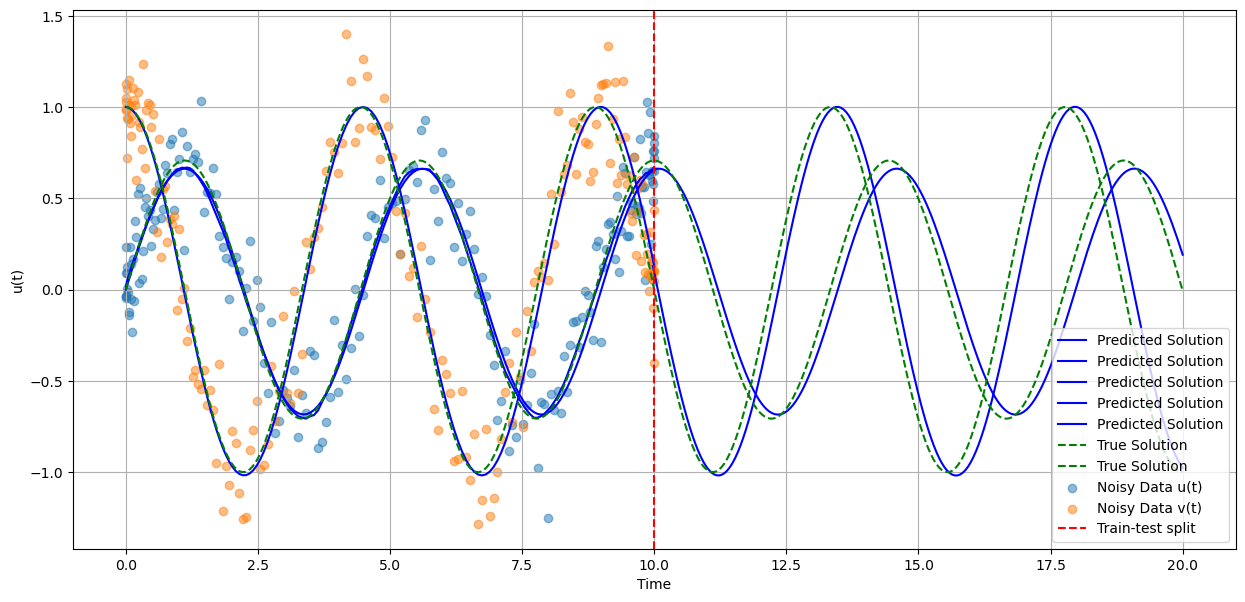

In [189]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
plt.plot(t_ho_cheb, y_pred_train, 'b', label='Predicted Solution')
plt.plot(t_ho_cheb, u_model, 'b', label='Predicted Solution')
plt.plot(t_test_ho_cheb[N-1:], y_pred_test, 'b', label='Predicted Solution')
plt.plot(t_test_ho_cheb, y_test_ho_cheb, 'g--', label='True Solution')
plt.scatter(t_ho_cheb, y_noisy_ho_cheb.T[0], label='Noisy Data u(t)', alpha = 0.5)

plt.scatter(t_ho_cheb, y_noisy_ho_cheb.T[1], label='Noisy Data v(t)', alpha = 0.5)

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=end_time, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

### `1.3` Non-parametric collocation 

In [16]:
class NeuralODE_Collocation(nn.Module):
    """
    A neural network model for approximating ODE solutions using collocation.
    
    Attributes:
        layer_widths (list): List of integers specifying the width of each layer in the neural network.
    """
    layer_widths: list

    @nn.compact
    def __call__(self, y):
        """
        Forward pass through the neural network.        
        Args:

        Returns:
            jax.numpy.ndarray: Output of the neural network.
        """
        for width in self.layer_widths[:-1]:
            y = nn.Dense(width)(y)
            y = nn.tanh(y)
        y = nn.Dense(self.layer_widths[-1])(y)
        return y
    
    
def create_train_state_collocation(rng, layer_widths, input_shape, learning_rate):
    """
    Create and initialize the training state for the model.
    
    Args:
        rng (jax.random.PRNGKey): Random number generator key.
        layer_widths (list): List of integers specifying the width of each layer in the neural network.
        learning_rate (float): Learning rate for the optimizer.
    
    Returns:
        train_state.TrainState: Initialized training state.
    """
    model = NeuralODE_Collocation(layer_widths=layer_widths)
    u_init, v_init = 0.0, 1.0
    y_init = jnp.array([u_init, v_init])
    params = model.init(rng, y_init)['params']
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)


def loss_fn_collocation(params, apply_fn, y_init, observed_derivative, observed_data):
    """
    Compute the loss as the mean absolute error between predicted and observed derivatives.
    
    Args:
        params (dict): Parameters of the model.
        apply_fn (function): Function to apply the model to input data.
        y_init
        observed_derivative (jax.numpy.ndarray): True derivatives at the input features.
    
    Returns:
        float: The mean absolute error loss.
    """
    pred_derivatives = []
    for data in observed_data:
        pred_derivative = apply_fn({'params': params}, data)
        pred_derivatives.append(pred_derivative)
        
    return jnp.mean(jnp.abs(jnp.array(pred_derivatives) - observed_derivative))

@jit
def train_step_collocation(state, y_init, observed_derivative, observed_data):
    """
    Perform a single training step by computing the loss and its gradients,
    and then updating the model parameters.

    Args:
        state (train_state.TrainState): Contains model state including parameters.
        u (jax.numpy.ndarray): Input data for u.
        v (jax.numpy.ndarray): Input data for v.
        observed_derivative (jax.numpy.ndarray): True derivatives to compare against model predictions.

    Returns:
        tuple: Updated state and loss value.
    """
    def loss_fn(params):
        return loss_fn_collocation(params, state.apply_fn, y_init, observed_derivative, observed_data)
    
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss

def train_collocation(state, y_init, observed_derivative, observed_data, num_epochs=1000):
    """
    Train the model using the collocation method for a given number of epochs.
    
    Args:
        state (train_state.TrainState): Initial state of the model.
        y_init .....?
        observed_data (jax.numpy.ndarray): True derivatives to compare against model predictions.
        num_epochs (int, optional): Number of training epochs. Default is 1000.
    
    Returns:
        train_state.TrainState: Trained model state.
    """
    for epoch in range(num_epochs):
        state, loss = train_step_collocation(state, y_init, observed_derivative, observed_data)
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss}')
    return state

def neural_ode(state, y_init, t):
    """

    """
    def func(y, t):
        return state.apply_fn({'params': state.params}, y)
    
    return odeint(func, y_init, t)

In [17]:
# estimated_derivative_ho_cheb, estimated_solution_ho_cheb = collocate_data(y_noisy_ho_cheb, t_ho_cheb, 'EpanechnikovKernel', bandwidth=0.5)

layer_widths = [2, 50, 50, 2] 
learning_rate = 1e-3

# create the new state
rng = random.PRNGKey(0)
input_shape = (1, )
state = create_train_state_collocation(rng, layer_widths, input_shape, learning_rate)

start_timer = time.time()
# train_collocation(state_coll, t2, estimated_derivative.T, num_epochs= 10000)
t_t = jnp.array([t_ho_cheb,t_ho_cheb])
trained_state = train_collocation(state, initial_state, estimated_derivative_ho_cheb.T, y_noisy_ho_cheb, num_epochs=1000)
end_timer = time.time()
timer = end_timer - start_timer
print(f"Time elapsed: {timer}")

KeyboardInterrupt: 

In [130]:
# generate predictions t_test_ho_cheb, y_test_ho_cheb,
y_pred = neural_ode(trained_state, initial_state, t_test_ho_cheb)

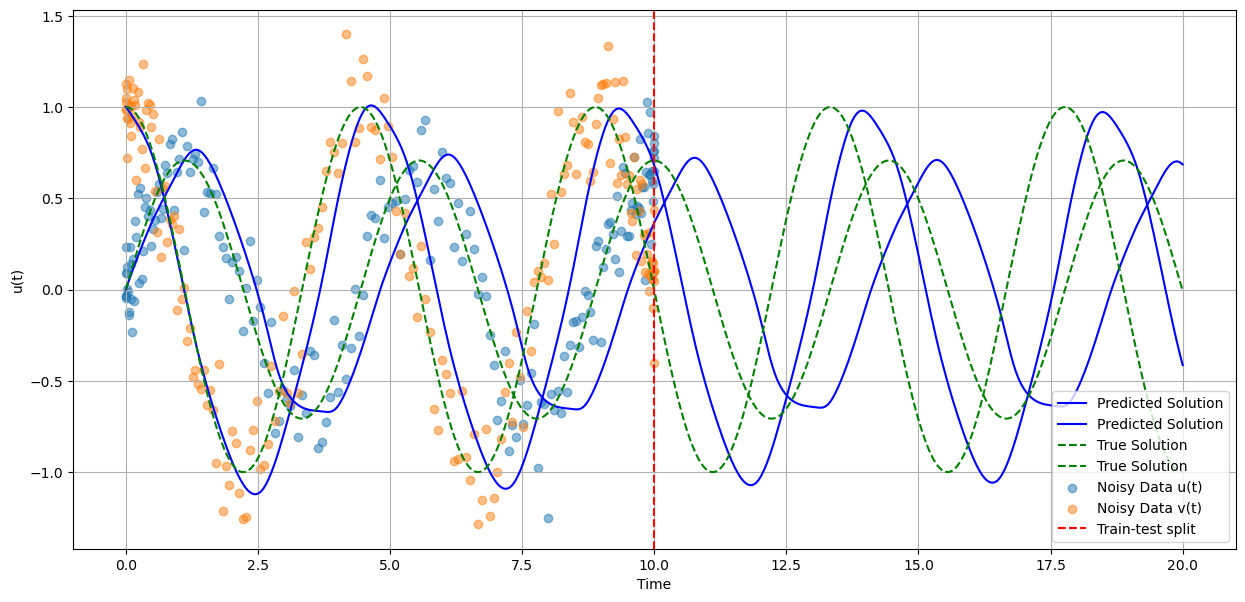

In [131]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
# plt.plot(t_ho_cheb, y_pred_train, 'b', label='Predicted Solution')
plt.plot(t_test_ho_cheb, y_pred, 'b', label='Predicted Solution')
plt.plot(t_test_ho_cheb, y_test_ho, 'g--', label='True Solution')

plt.scatter(t_ho_cheb, y_noisy_ho_cheb.T[0], label='Noisy Data u(t)', alpha = 0.5)
plt.scatter(t_ho_cheb, y_noisy_ho_cheb.T[1], label='Noisy Data v(t)', alpha = 0.5)

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=end_time, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

## `2.0` Van Der Pol 
### `2.1 JAX neural net using ODEINT`

In [5]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.1
ode_type, params = "van_der_pol", {"mu": 1, "omega": 1}
start_time, end_time = 0, 15
spacing_type = "equally_spaced" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_vdp, y_vdp, y_noisy_vdp, true_derivatives_vdp = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy_vdp = np.array(jnp.squeeze(y_noisy_vdp))
t_vdp = np.array(jnp.squeeze(t_vdp))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
#weights = compute_weights(t_vdp)
#D_vdp = np.array(lagrange_derivative(t_vdp, weights))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test_vdp, y_test_vdp, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, end_time*2, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
#estimated_derivative_vdp, estimated_solution_vdp = collocate_data(y_noisy_vdp, t_vdp, 'EpanechnikovKernel', bandwidth=0.5)

In [18]:
y_pred_results = {}

layer_widths = [3, 64, 64, 2]
learning_rate = 1e-3
rng = PRNGKey(0)

neural_ode_model = NeuralODE(layer_widths=layer_widths, time_invariant=False)
state = neural_ode_model.create_train_state(rng, learning_rate)

start_timer = time.time()
# train(self, state, t, observed_data, y0, num_epochs=1000):
trained_state = neural_ode_model.train(state, t_vdp, y_noisy_vdp, initial_state, num_epochs=10000)
end_timer = time.time()
timer = end_timer - start_timer
print(f"Time elapsed: {timer}")

y_train_pred = neural_ode_model.neural_ode(trained_state.params, initial_state, t_vdp, trained_state)

#---------------------------------------------SAVE RESULT---------------------------------------------#
y1 = y_train_pred[-1, :]
# def neural_ode(self, params, y0, t, state):
y_test_pred = neural_ode_model.neural_ode(trained_state.params, y1, t_test_vdp[N-1:], trained_state)
y_pred_results[1] = {"y_train_pred": y_train_pred, "y_test_pred": y_test_pred,
                            "time_elapsed": timer, "y_noisy":y_noisy_vdp}


Epoch 100, Loss: 1147.2825149955936
Epoch 200, Loss: 1136.4461647698217
Epoch 300, Loss: 1129.8744074973245
Epoch 400, Loss: 1124.1891115414232
Epoch 500, Loss: 1119.2008991933794
Epoch 600, Loss: 1114.6488748454788
Epoch 700, Loss: 1109.9279770144808
Epoch 800, Loss: 1104.4804137235524
Epoch 900, Loss: 1097.714609045827
Epoch 1000, Loss: 1088.9524820215793
Epoch 1100, Loss: 1085.2727547244667
Epoch 1200, Loss: 1073.733693969444
Epoch 1300, Loss: 1059.4723023652623
Epoch 1400, Loss: 985.6251937649718
Epoch 1500, Loss: 214.78944270465027
Epoch 1600, Loss: 185.68224554133525
Epoch 1700, Loss: 174.8345390497757
Epoch 1800, Loss: 188.45775425091108
Epoch 1900, Loss: 162.72972542366895
Epoch 2000, Loss: 155.99571350547532
Epoch 2100, Loss: 150.6532341889053
Epoch 2200, Loss: 145.38757535651686
Epoch 2300, Loss: 146.12683439010203
Epoch 2400, Loss: 135.05878161069612
Epoch 2500, Loss: 132.30185797152427
Epoch 2600, Loss: 127.2643665677293
Epoch 2700, Loss: 121.37451404031799
Epoch 2800, Loss

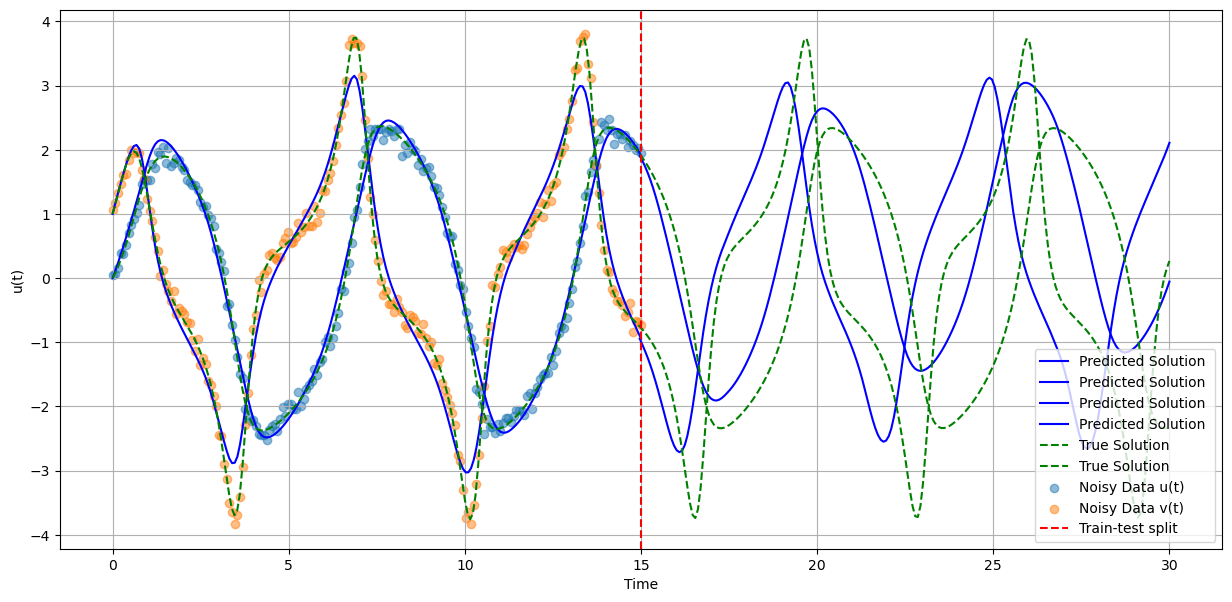

In [190]:
result = y_pred_results[1]

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
plt.plot(t_vdp, result['y_train_pred'], 'b', label='Predicted Solution ')
plt.plot(t_test_vdp[N-1:], result['y_test_pred'], 'b', label='Predicted Solution')
plt.plot(t_test_vdp, y_test_vdp, 'g--', label='True Solution')

plt.scatter(t_vdp, y_noisy_vdp.T[0], label='Noisy Data u(t)', alpha = 0.5)
plt.scatter(t_vdp, y_noisy_vdp.T[1], label='Noisy Data v(t)', alpha = 0.5)

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=15, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

### `2.2` Optimization with constraints in Pyomo, Ipopt, + regularization

In [191]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.1
ode_type, params = "van_der_pol", {"mu": 1, "omega": 1}
start_time, end_time = 0, 15
spacing_type = "chebyshev" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_vdp_cheb, y_vdp_cheb, y_noisy_vdp_cheb, true_derivatives_vdp_cheb = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy_vdp_cheb = np.array(jnp.squeeze(y_noisy_vdp_cheb))
t_vdp_cheb = np.array(jnp.squeeze(t_vdp_cheb))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
weights_vdp_cheb = compute_weights(t_vdp_cheb)
D_vdp_cheb = np.array(lagrange_derivative(t_vdp_cheb, weights_vdp_cheb))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test_vdp_cheb, y_test_vdp_cheb, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, end_time*2, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
estimated_derivative_vdp_cheb, estimated_solution_vdp_cheb = collocate_data(y_noisy_vdp_cheb, t_vdp_cheb, 'EpanechnikovKernel', bandwidth=0.5)

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


In [206]:
class ODEOptimizationModel:
    def __init__(self, y_observed, t, first_derivative_matrix, layer_sizes, extra_input = None, penalty_lambda=100, max_iter=500, act_func="tanh", w_init_method="random", y_init = None):
        self.y_observed = y_observed
        self.t = t
        self.first_derivative_matrix = first_derivative_matrix
        self.penalty_lambda = penalty_lambda
        self.max_iter = max_iter
        self.act_func = act_func
        self.w_init_method = w_init_method
        self.layer_sizes = layer_sizes
        self.model = ConcreteModel()
        self.y_init = y_init
        self.w_init_method = w_init_method
        self.extra_input = extra_input # only 1D input is supported for now

    def initialize_weights(self, shape):
        if self.w_init_method == 'random':
            return np.random.randn(*shape) * 0.1
        elif self.w_init_method == 'xavier':
            return np.random.randn(*shape) * np.sqrt(2 / (shape[0] + shape[1]))
        elif self.w_init_method == 'he':
            return np.random.randn(*shape) * np.sqrt(2 / shape[0])
        else:
            raise ValueError("Unsupported initialization method. Use 'random', 'xavier', or 'he'.")

    def initialize_biases(self, size):
        return np.random.randn(size) * 0.1

    def build_model(self):
        N = len(self.t)
        model = self.model
        model.t_idx = RangeSet(0, N - 1)

        lower_bound = -10.0
        upper_bound = 10.0
        
        if self.y_init == None:
            model.u = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=0.1, bounds=(lower_bound, upper_bound))
            model.v = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=0.1, bounds=(lower_bound, upper_bound))
        else:
            model.u = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=np.array(self.y_init[0]), bounds=(lower_bound, upper_bound))
            model.v = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=np.array(self.y_init[1]), bounds=(lower_bound, upper_bound))

        if len(self.layer_sizes) == 3:
            input_size = self.layer_sizes[0]
            hidden_size = self.layer_sizes[1]
            output_size = self.layer_sizes[2]

            weight_bounds = (-100.0, 100.0)

            model.W1 = pyo.Var(range(hidden_size), range(input_size), initialize=lambda m, i, j: self.initialize_weights((hidden_size, input_size))[i, j], bounds=weight_bounds)
            model.b1 = pyo.Var(range(hidden_size), initialize=lambda m, i: self.initialize_biases(hidden_size)[i], bounds=weight_bounds)
            model.W2 = pyo.Var(range(output_size), range(hidden_size), initialize=lambda m, i, j: self.initialize_weights((output_size, hidden_size))[i, j], bounds=weight_bounds)
            model.b2 = pyo.Var(range(output_size), initialize=lambda m, i: self.initialize_biases(output_size)[i], bounds=weight_bounds)
            
            # >>>>>>>>>>>>>>>>>>>>> BATCH NORMALIZATION <<<<<<<<<<<<<<<<<<<< #
            """model.gamma1 = pyo.Var(range(hidden_size), initialize=1.0)
            model.beta1 = pyo.Var(range(hidden_size), initialize=0.0)
            model.gamma2 = pyo.Var(range(output_size), initialize=1.0)
            model.beta2 = pyo.Var(range(output_size), initialize=0.0)"""
            # >>>>>>>>>>>>>>>>>>>>> BATCH NORMALIZATION <<<<<<<<<<<<<<<<<<<< #
            
        # >>>>>>>>>>>>>>>>>>>>> CONSTRAINTS METHOD 0 <<<<<<<<<<<<<<<<<<<< #
        # penalty_terms = []
        model.ode = ConstraintList()
        for i in range(1, N):
            du_dt = sum(self.first_derivative_matrix[i, j] * model.u[j] for j in range(N))
            dv_dt = sum(self.first_derivative_matrix[i, j] * model.v[j] for j in range(N))
            
            
            nn_input = [model.u[i], model.v[i]]
            
            if self.extra_input is not None:
                nn_input.append(self.extra_input[i])
                
            nn_u, nn_v = self.nn_output(nn_input, model)

            collocation_constraint_u = nn_u - du_dt
            collocation_constraint_v = nn_v - dv_dt

            model.ode.add((collocation_constraint_u) == 0.0)
            model.ode.add((collocation_constraint_v) == 0.0)
            
            # penalty_terms.append((nn_u)**2 + (nn_v)**2)
            
        def _objective(m):
            data_fit = sum((m.u[i] - self.y_observed[i, 0])**2 + (m.v[i] - self.y_observed[i, 1])**2 for i in m.t_idx)
            smoothing_u = sum((m.u[i+1] - m.u[i])**2 for i in range(len(m.t_idx)-1))
            smoothing_v = sum((m.v[i+1] - m.v[i])**2 for i in range(len(m.t_idx)-1))
            smoothing_term = (smoothing_u + smoothing_v)
            
            reg = sum(m.W1[j, k]**2 for j in range(self.layer_sizes[1]) for k in range(self.layer_sizes[0])) + \
            sum(m.W2[j, k]**2 for j in range(self.layer_sizes[2]) for k in range(self.layer_sizes[1])) + \
            sum(m.b1[j]**2 for j in range(self.layer_sizes[1])) + \
            sum(m.b2[j]**2 for j in range(self.layer_sizes[2]))
            
            return data_fit #+ reg*0.3

        model.obj = Objective(rule=_objective, sense=pyo.minimize)
        self.model = model 
            
    def nn_output(self, nn_input, m):

        if len(self.layer_sizes) == 3:
            hidden = [sum(m.W1[j, k] * nn_input[k] for k in range(self.layer_sizes[0])) + m.b1[j] for j in range(self.layer_sizes[1])]
            
            # >>>>>>>>>>>>>>>>>>>>> BATCH NORMALIZATION <<<<<<<<<<<<<<<<<<<< #
            """mean_hidden = sum(hidden) / len(hidden)
            var_hidden = sum((h - mean_hidden)**2 for h in hidden) / len(hidden)
            hidden_norm = [(h - mean_hidden) / pyo.sqrt(var_hidden + 1e-5) for h in hidden]
            hidden_bn = [m.gamma1[j] * hidden_norm[j] + m.beta1[j] for j in range(len(hidden_norm))]"""
            # >>>>>>>>>>>>>>>>>>>>> BATCH NORMALIZATION <<<<<<<<<<<<<<<<<<<< #
            
            if self.act_func == "tanh":
                hidden = [pyo.tanh(h) for h in hidden]
            elif self.act_func == "sigmoid":
                hidden = [1 / (1 + pyo.exp(-h)) for h in hidden]
            elif self.act_func == "softplus":
                hidden = [pyo.log(1 + pyo.exp(h)) for h in hidden]
            outputs = [sum(m.W2[j, k] * hidden[k] for k in range(self.layer_sizes[1])) + m.b2[j] for j in range(self.layer_sizes[2])]
            return outputs  # Ensure outputs are returned

    def solve_model(self):
        solver = pyo.SolverFactory('ipopt')
        
        if self.max_iter:
            solver.options['max_iter'] = self.max_iter
            
        solver.options['print_level'] = 5
        solver.options['tol'] = 1e-8
        solver.options["dual_inf_tol"] = 1e-5
        solver.options["compl_inf_tol"] = 1e-5
        solver.options["constr_viol_tol"] = 1e-5

        # solver.options['constr_viol_tol'] = 1e-5
        # solver.options['bound_relax_factor'] = 1e-6  # Default is 1e-8
        # solver.options['compl_inf_tol'] = 1e-2
        # solver.options['dual_inf_tol'] = 10000
        # solver.options['nlp_scaling_method'] = 'gradient-based'  # Or 'user-scaling'
        # solver.options['mu_strategy'] = 'adaptive' # 'monotone'
        # solver.options['check_derivatives_for_naninf'] = 'yes'
        solver.options['halt_on_ampl_error'] = 'yes'
        # solver.options['linear_solver'] = 'mumps'  # Or try 'ma27', 'ma57', 'ma86' if available #DEFAULT 'mumps'
        
        result = solver.solve(self.model, tee=True)
        
        # ------------------- Extract solver information -------------------
        solver_time = result.solver.time
        termination_condition = result.solver.termination_condition
        message = result.solver.message
        
        # ----------------- Extracted information in a dictionary ----------
        solver_info = {
            'solver_time': solver_time,
            'termination_condition': termination_condition,
            'message': message
        }
        
        return solver_info

    def extract_solution(self):
        u = np.array([pyo.value(self.model.u[i]) for i in self.model.t_idx])
        v = np.array([pyo.value(self.model.v[i]) for i in self.model.t_idx])
        return u, v

    def extract_weights(self):
        weights = {}
        if len(self.layer_sizes) == 3:
            W1 = np.array([[pyo.value(self.model.W1[j, k]) for k in range(self.layer_sizes[0])] for j in range(self.layer_sizes[1])])
            b1 = np.array([pyo.value(self.model.b1[j]) for j in range(self.layer_sizes[1])])
            W2 = np.array([[pyo.value(self.model.W2[j, k]) for k in range(self.layer_sizes[1])] for j in range(self.layer_sizes[2])])
            b2 = np.array([pyo.value(self.model.b2[j]) for j in range(self.layer_sizes[2])])
            weights['W1'], weights['b1'], weights['W2'], weights['b2'] = W1, b1, W2, b2
        return weights

    def predict(self, input):
        weights = self.extract_weights()

        if len(self.layer_sizes) == 3:
            W1, b1, W2, b2 = weights['W1'], weights['b1'], weights['W2'], weights['b2']
            hidden = jnp.tanh(jnp.dot(W1, input) + b1)
            outputs = jnp.dot(W2, hidden) + b2

        return outputs

    def mae(self, y_true, u, v):
        combined = np.vstack((u, v)).T
        mae_result = np.mean(np.abs(y_true - combined))
        return mae_result

if __name__ == "__main__":
    """ode_model = ODEOptimizationModel(y_observed, t, first_derivative_matrix)
    ode_model.build_model()
    ode_model.solve_model()
    u, v = ode_model.extract_solution()"""


In [207]:
y_noisy_vdp_cheb.shape

(200, 2)

In [208]:
%%time
layer_widths = [2, 10, 2]

ode_model = ODEOptimizationModel(y_noisy_vdp_cheb, t_vdp_cheb, D_vdp_cheb, layer_widths, max_iter = 1000, act_func = "tanh", y_init = estimated_solution_vdp_cheb, w_init_method = 'xavier') # , y_init = estimated_solution
ode_model.build_model()

start_timer_build = time.time()
result = ode_model.solve_model()
end_timer_build = time.time()
print(f"Model solving time: {end_timer_build - start_timer_build}")

u_model, v_model = ode_model.extract_solution()

Ipopt 3.14.16: max_iter=1000
print_level=5
tol=1e-08
dual_inf_tol=1e-05
compl_inf_tol=1e-05
constr_viol_tol=1e-05
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    96316
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    20619

Total number of variables............................:      452
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      452
                  

In [209]:
def system_dynamics(y, t):
    input = jnp.array([y[0], y[1]])
    print(input.shape)
    print(ode_model.predict(input).shape)
    du_dt, dv_dt = ode_model.predict(input)
    return jnp.array([du_dt, dv_dt])

initial_conditions = jnp.array([0.0, 1.0]) 
y_pred_train = odeint(system_dynamics, initial_conditions, t_vdp_cheb)    
mae_train = jnp.mean(jnp.abs(y_pred_train - y_vdp_cheb))
print (f"Train MAE: {mae_train}")


y1 = y_pred_train[-1, :]
y_pred_test = odeint(system_dynamics, y1, t_test_vdp_cheb[N-1:])
mae_test = jnp.mean(jnp.abs(y_pred_test - y_test_vdp_cheb[N-1:]))
print (f"Test MAE: {mae_test}")

(2,)
(2,)
Train MAE: 0.26537366926335015
Test MAE: 1.6531531872806453


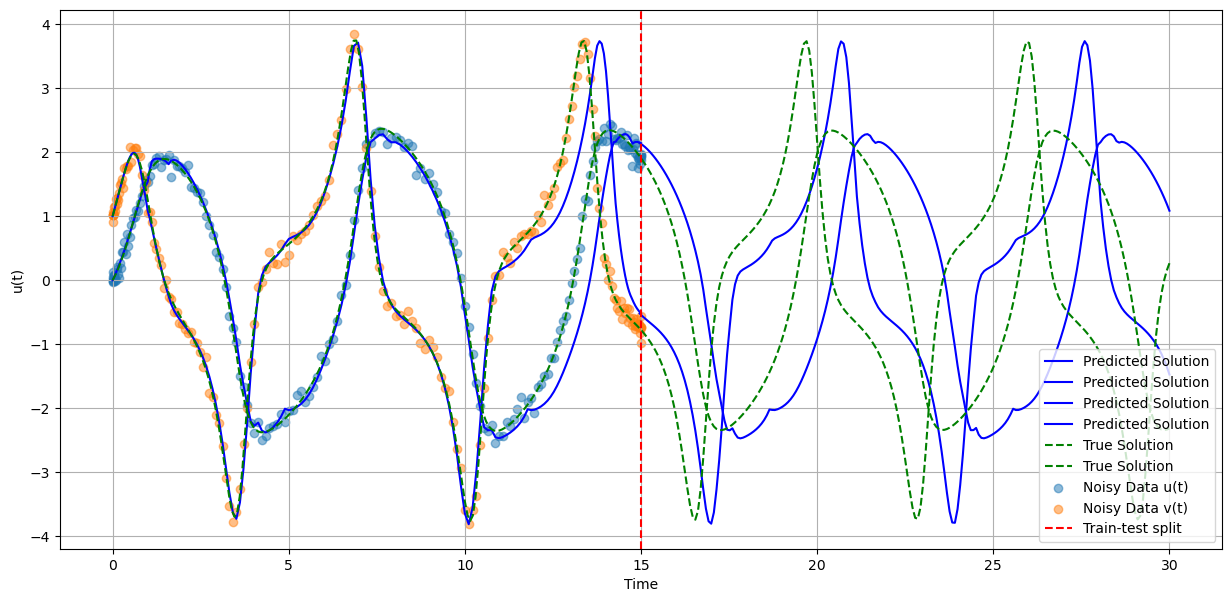

In [210]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
plt.plot(t_vdp_cheb, y_pred_train, 'b', label='Predicted Solution')
plt.plot(t_test_vdp_cheb[N-1:], y_pred_test, 'b', label='Predicted Solution')

plt.plot(t_test_vdp_cheb, y_test_vdp, 'g--', label='True Solution')

plt.scatter(t_vdp_cheb, y_noisy_vdp_cheb.T[0], label='Noisy Data u(t)', alpha = 0.5)
plt.scatter(t_vdp_cheb, y_noisy_vdp_cheb.T[1], label='Noisy Data v(t)', alpha = 0.5)

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=end_time, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

## `3.0` Damped Oscillator

In [81]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.1
ode_type, params = "damped_oscillation", {"damping_factor": 0.1, "omega_squared": 1}
start_time, end_time = 0, 10
spacing_type = "equally_spaced" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_do, y_do, y_noisy_do, true_derivatives_do = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy_do = np.array(jnp.squeeze(y_noisy_do))
t_do = np.array(jnp.squeeze(t_do))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
weights_do = compute_weights(t_do)
D_do = np.array(lagrange_derivative(t_do, weights_do))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test_do, y_test_do, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, end_time*2, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
estimated_derivative_do, estimated_solution_do = collocate_data(y_noisy_do, t_do, 'EpanechnikovKernel', bandwidth=0.5)

In [86]:
y_pred_results = {}

layer_widths = [3, 64, 64, 2]
learning_rate = 1e-3
rng = PRNGKey(0)

neural_ode_model = NeuralODE(layer_widths=layer_widths, time_invariant=False)
state = neural_ode_model.create_train_state(rng, learning_rate)

start_timer = time.time()
# train(self, state, t, observed_data, y0, num_epochs=1000):
trained_state = neural_ode_model.train(state, t_do, y_noisy_do, initial_state, num_epochs=1200)
end_timer = time.time()
timer = end_timer - start_timer
print(f"Time elapsed: {timer}")

y_train_pred = neural_ode_model.neural_ode(trained_state.params, initial_state, t_do, trained_state)

#---------------------------------------------SAVE RESULT---------------------------------------------#
y1 = y_train_pred[-1, :]
# def neural_ode(self, params, y0, t, state):
y_test_pred = neural_ode_model.neural_ode(trained_state.params, y1, t_test_do[N-1:], trained_state)
y_pred_results[2] = {"y_train_pred": y_train_pred, "y_test_pred": y_test_pred,
                            "time_elapsed": timer, "y_noisy":y_noisy_do}


Epoch 0, Loss: 1.7764176233505817
Epoch 100, Loss: 0.47328373790386297
Epoch 200, Loss: 0.46056727436182493
Epoch 300, Loss: 0.4130150612117916
Epoch 400, Loss: 0.21831664174476434
Epoch 500, Loss: 0.10612433900206007
Epoch 600, Loss: 0.08617760497020051
Epoch 700, Loss: 0.08020244780934252
Epoch 800, Loss: 0.07958396030251551
Epoch 900, Loss: 0.07800944015213632
Epoch 1000, Loss: 0.07663095509006794
Epoch 1100, Loss: 0.0764536443305503
Time elapsed: 58.718703746795654


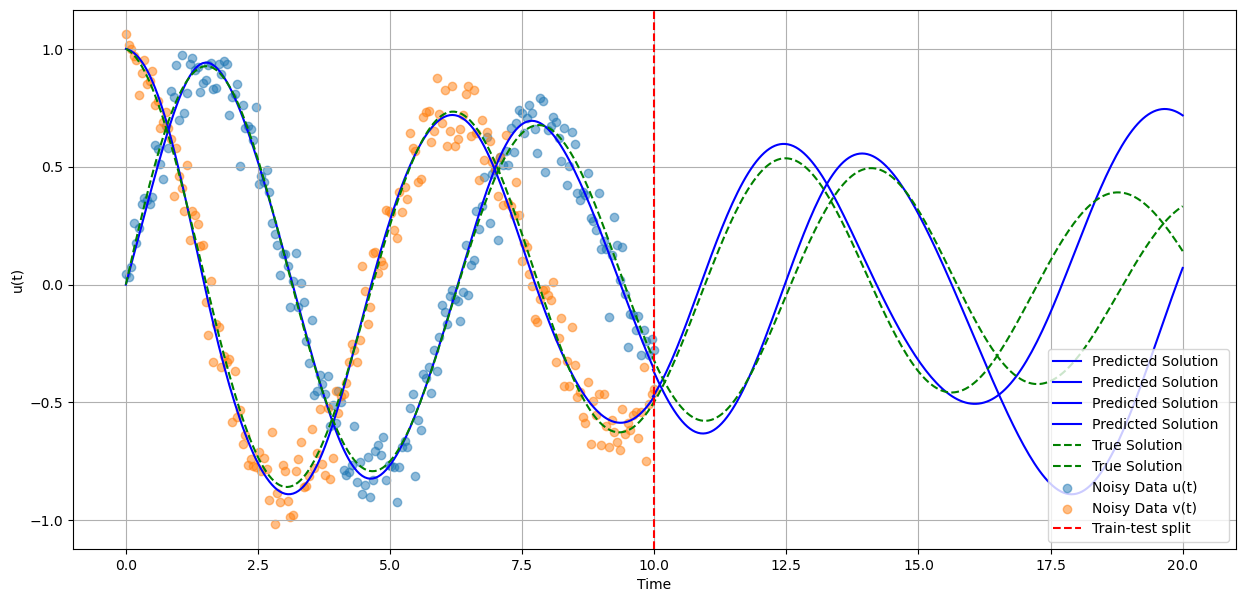

In [87]:
result = y_pred_results[2]

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
plt.plot(t_do, result['y_train_pred'], 'b', label='Predicted Solution ')
plt.plot(t_test_do[N-1:], result['y_test_pred'], 'b', label='Predicted Solution')
plt.plot(t_test_do, y_test_do, 'g--', label='True Solution')

plt.scatter(t_do, y_noisy_do.T[0], label='Noisy Data u(t)', alpha = 0.5)
plt.scatter(t_do, y_noisy_do.T[1], label='Noisy Data v(t)', alpha = 0.5)

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=end_time, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

## `3.2`

In [107]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.1
ode_type, params = "damped_oscillation", {"damping_factor": 0.1, "omega_squared": 1}
start_time, end_time = 0, 10
spacing_type = "chebyshev" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_do_cheb, y_do_cheb, y_noisy_do_cheb, true_derivatives_do_cheb = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy_do_cheb = np.array(jnp.squeeze(y_noisy_do_cheb))
t_do_cheb = np.array(jnp.squeeze(t_do_cheb))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
weights_do_cheb = compute_weights(t_do_cheb)
D_do_cheb = np.array(lagrange_derivative(t_do_cheb, weights_do_cheb))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test_do_cheb, y_test_do_cheb, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, end_time*2, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
estimated_derivative_do_cheb, estimated_solution_do_cheb = collocate_data(y_noisy_do_cheb, t_do_cheb, 'EpanechnikovKernel', bandwidth=0.5)

In [96]:
class ODEOptimizationModel:
    def __init__(self, y_observed, t, first_derivative_matrix, layer_sizes, extra_input = None, penalty_lambda=100, max_iter=500, act_func="tanh", w_init_method="random", y_init = None):
        self.y_observed = y_observed
        self.t = t
        self.first_derivative_matrix = first_derivative_matrix
        self.penalty_lambda = penalty_lambda
        self.max_iter = max_iter
        self.act_func = act_func
        self.w_init_method = w_init_method
        self.layer_sizes = layer_sizes
        self.model = ConcreteModel()
        self.y_init = y_init
        self.w_init_method = w_init_method
        self.extra_input = extra_input # only 1D input is supported for now

    def initialize_weights(self, shape):
        if self.w_init_method == 'random':
            return np.random.randn(*shape) * 0.1
        elif self.w_init_method == 'xavier':
            return np.random.randn(*shape) * np.sqrt(2 / (shape[0] + shape[1]))
        elif self.w_init_method == 'he':
            return np.random.randn(*shape) * np.sqrt(2 / shape[0])
        else:
            raise ValueError("Unsupported initialization method. Use 'random', 'xavier', or 'he'.")

    def initialize_biases(self, size):
        return np.random.randn(size) * 0.1

    def build_model(self):
        N = len(self.t)
        model = self.model
        model.t_idx = RangeSet(0, N - 1)

        lower_bound = -10.0
        upper_bound = 10.0
        
        if self.y_init == None:
            model.u = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=0.1, bounds=(lower_bound, upper_bound))
            model.v = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=0.1, bounds=(lower_bound, upper_bound))
        else:
            model.u = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=np.array(self.y_init[0]), bounds=(lower_bound, upper_bound))
            model.v = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=np.array(self.y_init[1]), bounds=(lower_bound, upper_bound))

        if len(self.layer_sizes) == 3:
            input_size = self.layer_sizes[0]
            hidden_size = self.layer_sizes[1]
            output_size = self.layer_sizes[2]

            weight_bounds = (-100.0, 100.0)

            model.W1 = pyo.Var(range(hidden_size), range(input_size), initialize=lambda m, i, j: self.initialize_weights((hidden_size, input_size))[i, j], bounds=weight_bounds)
            model.b1 = pyo.Var(range(hidden_size), initialize=lambda m, i: self.initialize_biases(hidden_size)[i], bounds=weight_bounds)
            model.W2 = pyo.Var(range(output_size), range(hidden_size), initialize=lambda m, i, j: self.initialize_weights((output_size, hidden_size))[i, j], bounds=weight_bounds)
            model.b2 = pyo.Var(range(output_size), initialize=lambda m, i: self.initialize_biases(output_size)[i], bounds=weight_bounds)
            
            # >>>>>>>>>>>>>>>>>>>>> BATCH NORMALIZATION <<<<<<<<<<<<<<<<<<<< #
            """model.gamma1 = pyo.Var(range(hidden_size), initialize=1.0)
            model.beta1 = pyo.Var(range(hidden_size), initialize=0.0)
            model.gamma2 = pyo.Var(range(output_size), initialize=1.0)
            model.beta2 = pyo.Var(range(output_size), initialize=0.0)"""
            # >>>>>>>>>>>>>>>>>>>>> BATCH NORMALIZATION <<<<<<<<<<<<<<<<<<<< #
            
        # >>>>>>>>>>>>>>>>>>>>> CONSTRAINTS METHOD 0 <<<<<<<<<<<<<<<<<<<< #
        penalty_terms = []
        model.ode = ConstraintList()
        for i in range(1, N):
            du_dt = sum(self.first_derivative_matrix[i, j] * model.u[j] for j in range(N))
            dv_dt = sum(self.first_derivative_matrix[i, j] * model.v[j] for j in range(N))
            
            
            nn_input = [model.u[i], model.v[i]]
            
            if self.extra_input is not None:
                nn_input.append(self.extra_input[i])
                
            nn_u, nn_v = self.nn_output(nn_input, model)

            collocation_constraint_u = nn_u - du_dt
            collocation_constraint_v = nn_v - dv_dt

            model.ode.add(collocation_constraint_u == 0)
            model.ode.add(collocation_constraint_v == 0)
            
            penalty_terms.append((nn_u)**2 + (nn_v)**2)
            
        def _objective(m):
            data_fit = sum((m.u[i] - self.y_observed[i, 0])**2 + (m.v[i] - self.y_observed[i, 1])**2 for i in m.t_idx)
            smoothing_u = sum((m.u[i+1] - m.u[i])**2 for i in range(len(m.t_idx)-1))
            smoothing_v = sum((m.v[i+1] - m.v[i])**2 for i in range(len(m.t_idx)-1))
            smoothing_term = (smoothing_u + smoothing_v)
            
            reg = sum(m.W1[j, k]**2 for j in range(self.layer_sizes[1]) for k in range(self.layer_sizes[0])) + \
            sum(m.W2[j, k]**2 for j in range(self.layer_sizes[2]) for k in range(self.layer_sizes[1])) + \
            sum(m.b1[j]**2 for j in range(self.layer_sizes[1])) + \
            sum(m.b2[j]**2 for j in range(self.layer_sizes[2]))
            
            return data_fit + reg*0.1

        model.obj = Objective(rule=_objective, sense=pyo.minimize)
        self.model = model 
            
    def nn_output(self, nn_input, m):

        if len(self.layer_sizes) == 3:
            hidden = [sum(m.W1[j, k] * nn_input[k] for k in range(self.layer_sizes[0])) + m.b1[j] for j in range(self.layer_sizes[1])]
            
            # >>>>>>>>>>>>>>>>>>>>> BATCH NORMALIZATION <<<<<<<<<<<<<<<<<<<< #
            """mean_hidden = sum(hidden) / len(hidden)
            var_hidden = sum((h - mean_hidden)**2 for h in hidden) / len(hidden)
            hidden_norm = [(h - mean_hidden) / pyo.sqrt(var_hidden + 1e-5) for h in hidden]
            hidden_bn = [m.gamma1[j] * hidden_norm[j] + m.beta1[j] for j in range(len(hidden_norm))]"""
            # >>>>>>>>>>>>>>>>>>>>> BATCH NORMALIZATION <<<<<<<<<<<<<<<<<<<< #
            
            if self.act_func == "tanh":
                hidden = [pyo.tanh(h) for h in hidden]
            elif self.act_func == "sigmoid":
                hidden = [1 / (1 + pyo.exp(-h)) for h in hidden]
            elif self.act_func == "softplus":
                hidden = [pyo.log(1 + pyo.exp(h)) for h in hidden]
            outputs = [sum(m.W2[j, k] * hidden[k] for k in range(self.layer_sizes[1])) + m.b2[j] for j in range(self.layer_sizes[2])]
            return outputs  # Ensure outputs are returned

    def solve_model(self):
        solver = pyo.SolverFactory('ipopt')
        
        if self.max_iter:
            solver.options['max_iter'] = self.max_iter
            
        solver.options['print_level'] = 5
        solver.options['tol'] = 1e-7 # Set tolerance if needed
        # solver.options['constr_viol_tol'] = 1e-5
        # solver.options['bound_relax_factor'] = 1e-6  # Default is 1e-8
        # solver.options['compl_inf_tol'] = 1e-2
        # solver.options['dual_inf_tol'] = 10000
        # solver.options['nlp_scaling_method'] = 'gradient-based'  # Or 'user-scaling'
        # solver.options['mu_strategy'] = 'adaptive' # 'monotone'
        # solver.options['check_derivatives_for_naninf'] = 'yes'
        solver.options['halt_on_ampl_error'] = 'yes'
        # solver.options['linear_solver'] = 'mumps'  # Or try 'ma27', 'ma57', 'ma86' if available #DEFAULT 'mumps'
        
        result = solver.solve(self.model, tee=True)
        
        # ------------------- Extract solver information -------------------
        solver_time = result.solver.time
        termination_condition = result.solver.termination_condition
        message = result.solver.message
        
        # ----------------- Extracted information in a dictionary ----------
        solver_info = {
            'solver_time': solver_time,
            'termination_condition': termination_condition,
            'message': message
        }
        
        return solver_info

    def extract_solution(self):
        u = np.array([pyo.value(self.model.u[i]) for i in self.model.t_idx])
        v = np.array([pyo.value(self.model.v[i]) for i in self.model.t_idx])
        return u, v

    def extract_weights(self):
        weights = {}
        if len(self.layer_sizes) == 3:
            W1 = np.array([[pyo.value(self.model.W1[j, k]) for k in range(self.layer_sizes[0])] for j in range(self.layer_sizes[1])])
            b1 = np.array([pyo.value(self.model.b1[j]) for j in range(self.layer_sizes[1])])
            W2 = np.array([[pyo.value(self.model.W2[j, k]) for k in range(self.layer_sizes[1])] for j in range(self.layer_sizes[2])])
            b2 = np.array([pyo.value(self.model.b2[j]) for j in range(self.layer_sizes[2])])
            weights['W1'], weights['b1'], weights['W2'], weights['b2'] = W1, b1, W2, b2
        return weights

    def predict(self, input):
        weights = self.extract_weights()

        if len(self.layer_sizes) == 3:
            W1, b1, W2, b2 = weights['W1'], weights['b1'], weights['W2'], weights['b2']
            hidden = jnp.tanh(jnp.dot(W1, input) + b1)
            outputs = jnp.dot(W2, hidden) + b2

        return outputs

    def mae(self, y_true, u, v):
        combined = np.vstack((u, v)).T
        mae_result = np.mean(np.abs(y_true - combined))
        return mae_result

if __name__ == "__main__":
    """ode_model = ODEOptimizationModel(y_observed, t, first_derivative_matrix)
    ode_model.build_model()
    ode_model.solve_model()
    u, v = ode_model.extract_solution()"""


In [108]:
layer_widths = [3, 10, 2]

start_timer_build = time.time()
ode_model = ODEOptimizationModel(y_noisy_do_cheb, t_do_cheb, D_do_cheb, layer_widths, extra_input = t_do_cheb, max_iter = 1000, act_func = "tanh", y_init = estimated_solution_do_cheb) # , y_init = estimated_solution
ode_model.build_model()
end_timer_build = time.time()

result = ode_model.solve_model()

u_model, v_model = ode_model.extract_solution()

def system_dynamics(y, t):
    input = jnp.array([y[0], y[1], t])
    du_dt, dv_dt = ode_model.predict(input)
    return jnp.array([du_dt, dv_dt])

Ipopt 3.14.16: max_iter=1000
print_level=5
tol=1e-08
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   100296
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    24681

Total number of variables............................:      462
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      462
                     variables with only upper bounds:        0
Total number of

In [109]:
initial_conditions = jnp.array([0.0, 1.0]) 
y_pred_train = odeint(system_dynamics, initial_conditions, t_do_cheb)    
mae_train = jnp.mean(jnp.abs(y_pred_train - y_do_cheb))
print (f"Train MAE: {mae_train}")


y1 = y_pred_train[-1, :]
y_pred_test = odeint(system_dynamics, y1, t_test_do_cheb[N-1:])
mae_test = jnp.mean(jnp.abs(y_pred_test - y_test_do_cheb[N-1:]))
print (f"Test MAE: {mae_test}")

Train MAE: 0.010639699922066639
Test MAE: 0.05943102668449373


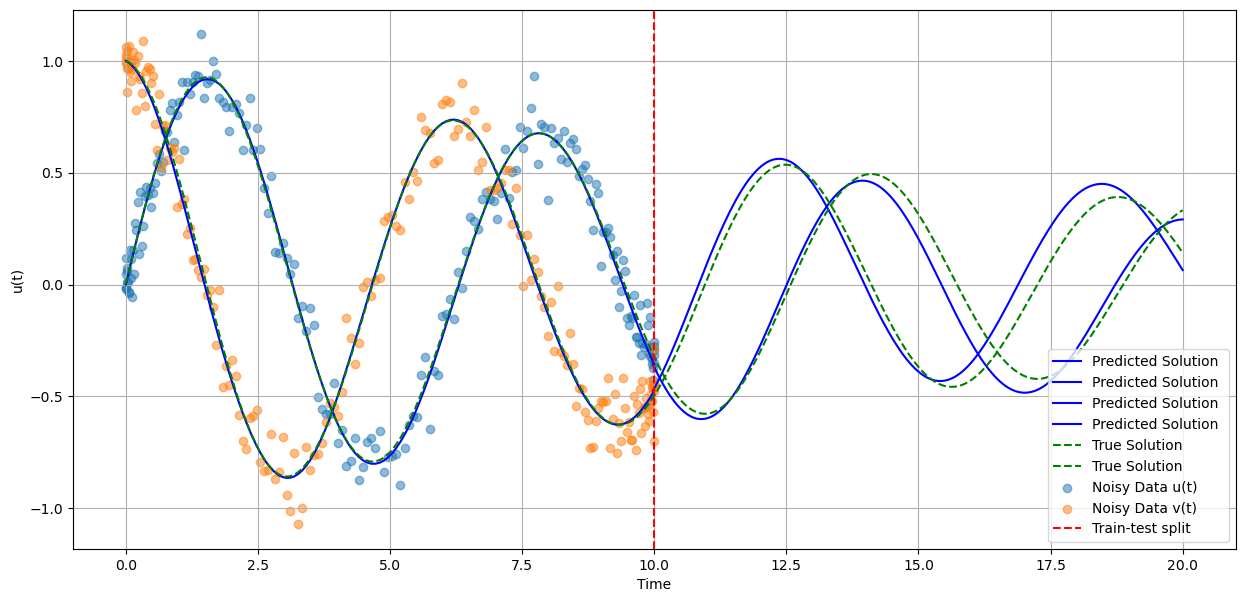

In [111]:
result = y_pred_results[2]

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
plt.plot(t_do_cheb, y_pred_train, 'b', label='Predicted Solution ')
plt.plot(t_test_do_cheb[N-1:], y_pred_test, 'b', label='Predicted Solution')
plt.plot(t_test_do_cheb, y_test_do_cheb, 'g--', label='True Solution')
plt.scatter(t_do_cheb, y_noisy_do_cheb.T[0], label='Noisy Data u(t)', alpha = 0.5)
plt.scatter(t_do_cheb, y_noisy_do_cheb.T[1], label='Noisy Data v(t)', alpha = 0.5)

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=end_time, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

## `1D-oscillator `

In [244]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.2
ode_type, params = "sinusoidal_oscillator", {"A": 0.25}
start_time, end_time = 0, 10
spacing_type = "equally_spaced" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = np.array(jnp.squeeze(y_noisy))
t = np.array(jnp.squeeze(t))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
weights = compute_weights(t)
D = np.array(lagrange_derivative(t, weights))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test, y_test, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, 20, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
estimated_derivative, estimated_solution = collocate_data(y_noisy, t, 'EpanechnikovKernel', bandwidth=0.5)

In [198]:
u_noisy = np.atleast_2d(y_noisy).T
r, c = u_noisy.shape
print(f"r : {r}; c : {c}")

u_estimated = np.atleast_2d(estimated_solution).T
r, c = u_estimated.shape
print(f"r : {r}; c : {c}")

r : 200; c : 1
r : 200; c : 1


In [227]:
u_noisy.T.shape

(1, 200)

In [251]:
importlib.reload(neural_net)
NeuralODE = neural_net.NeuralODE

In [264]:
y_pred_results = {}

layer_widths = [1, 64, 64, 1]
learning_rate = 1e-3
rng = PRNGKey(0)
batch_size = 32

node_model = NeuralODE(layer_widths, time_invariant=True)
state = node_model.create_train_state(rng, learning_rate)

start_timer = time.time()
# train(self, state, t, observed_data, y0, num_epochs=1000):
trained_state = node_model.train(state, t, u_noisy, initial_state, batch_size, num_epochs=2000)
end_timer = time.time()
timer = end_timer - start_timer
print(f"Time elapsed: {timer}")

Batch t: (32,), batch_observed_data: (32, 1), batch_y0: (1,)
Batch t: (32,), batch_observed_data: (32, 1), batch_y0: (1,)
Batch t: (32,), batch_observed_data: (32, 1), batch_y0: (1,)
Batch t: (32,), batch_observed_data: (32, 1), batch_y0: (1,)
Batch t: (32,), batch_observed_data: (32, 1), batch_y0: (1,)
Batch t: (32,), batch_observed_data: (32, 1), batch_y0: (1,)
Epoch 0, Average Loss: 0.1001017331731812
Epoch 100, Average Loss: 0.07300772044279473
Epoch 200, Average Loss: 0.06976605690272124
Epoch 300, Average Loss: 0.06796100028262184
Epoch 400, Average Loss: 0.06697180980245226
Epoch 500, Average Loss: 0.06643257123472049
Epoch 600, Average Loss: 0.06612334096543837
Epoch 700, Average Loss: 0.06593199435537729
Epoch 800, Average Loss: 0.06580477066541694
Epoch 900, Average Loss: 0.06571583100656332
Epoch 1000, Average Loss: 0.0656477522079864
Epoch 1100, Average Loss: 0.0655955995639481
Epoch 1200, Average Loss: 0.06555395592346676
Epoch 1300, Average Loss: 0.06551886802379965
Epoch

In [265]:
y_train_pred = node_model.neural_ode(trained_state.params, initial_state, t, trained_state)

In [266]:
#---------------------------------------------SAVE RESULT---------------------------------------------#
y1 = y_train_pred[-1, :]

# def neural_ode(self, params, y0, t, state):
# y_test_pred = neural_ode_model.neural_ode(trained_state.params, initial_state, t_test_ho, trained_state)

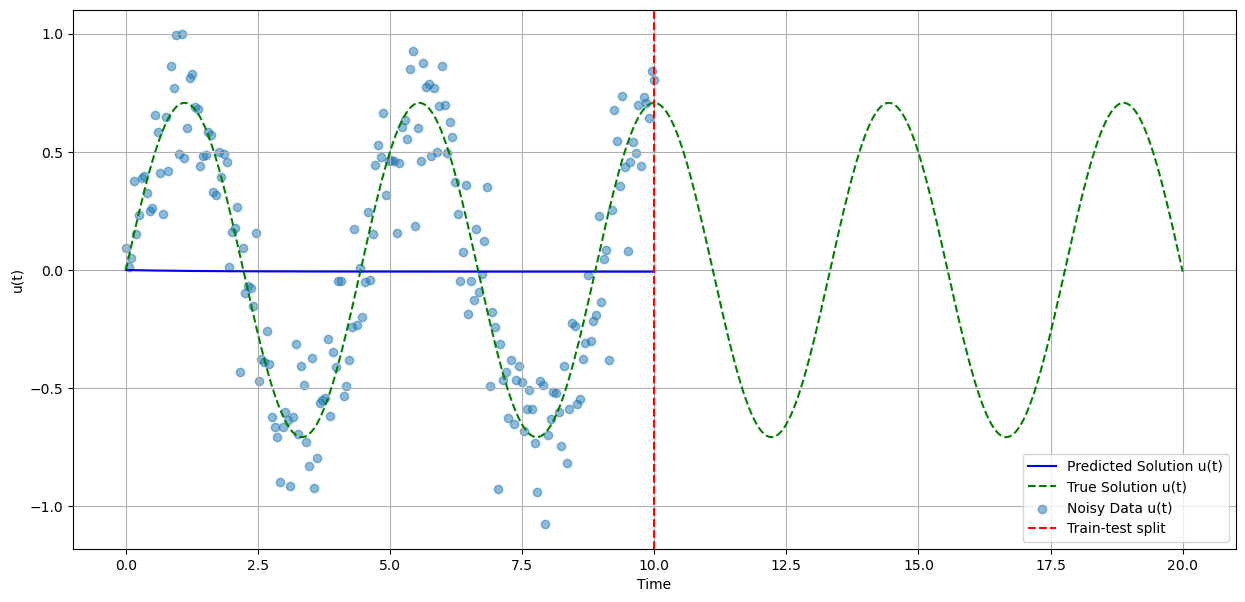

In [267]:
#result = y_pred_results[0]

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
plt.plot(t_ho, y_train_pred, 'b', label='Predicted Solution u(t)')
#plt.plot(t_test_ho[N-1:], result['y_test_pred'].T, 'b', label='Predicted Solution u(t')
plt.plot(t_test_ho, y_test_ho.T[0], 'g--', label='True Solution u(t)')
plt.scatter(t_ho, y_noisy_ho.T[0], label='Noisy Data u(t)', alpha = 0.5)

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=end_time, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()